In [196]:
import pandas as pd
import pymongo
from numba import vectorize,float64
import numpy as np
from scipy.stats import chi2_contingency,percentileofscore
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

%matplotlib inline
sns.set_context("poster")

In [2]:
client = pymongo.MongoClient()
db = client.swatford

In [3]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [4]:
%run equations.py

In [5]:
n = db.genes.descs.original.find().count()
gene_uid["pmi"] = pmi(gene_uid.gd_freq.values,gene_uid.d_freq.values,gene_uid.g_freq.values,n)
gene_uid["npmi"] = npmi(gene_uid.pmi.values,gene_uid.gd_freq.values,n)

In [6]:
gene_uid[gene_uid.gd_freq>2][["gene_id","uid","npmi"]].to_csv("emcon.txt",sep="\t",index=False)

In [7]:
uid_name = {doc["uid"]:doc["name"] for doc in db.medline.descs.find({})}

In [8]:
gene_uid["name"] = gene_uid.uid.map(pd.Series(uid_name))

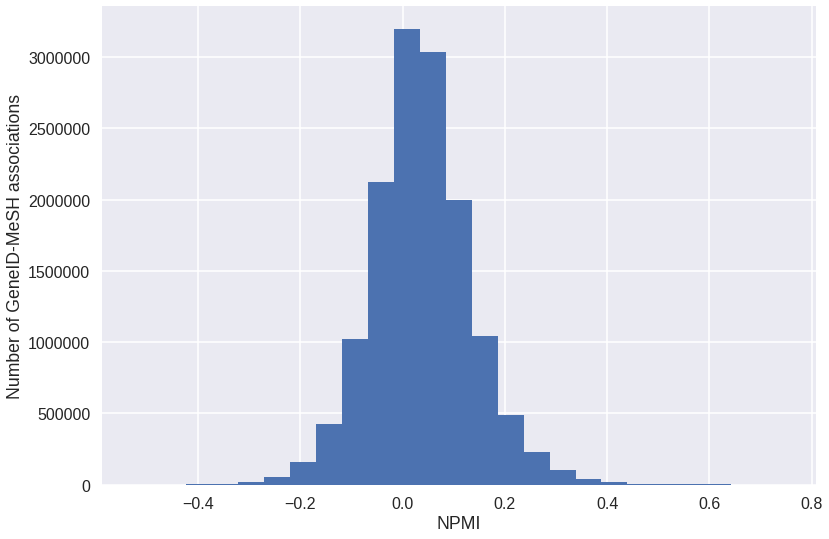

In [9]:
gene_uid.npmi.hist(bins=25)
plt.ylabel("Number of GeneID-MeSH associations")
plt.xlabel("NPMI")
plt.savefig("EMCON_NPMI_dist.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [10]:
bc_genes = pd.read_pickle("../data/SSI/ssi_gene_list.p")

In [11]:
genes = set(gene_uid.gene_id.unique())

In [12]:
random_gene_lists = np.random.choice(list(genes),(1000,len(bc_genes)))

In [13]:
bc_uids = ["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]

In [14]:
uid_tn = pd.DataFrame([{"uid":doc["uid"],"tn":tn} 
                       for doc in db.medline.descs.find({"tn":{"$exists":True}}) for tn in doc["tn"]])

In [15]:
bc_tns = uid_tn[uid_tn.uid.isin(bc_uids)]

In [16]:
bc_children = db.medline.descs.distinct("uid",{"ancestors":{"$in":list(bc_tns.tn.values)}})

In [17]:
bc_uids = set(bc_children)|set(bc_uids)

In [18]:
genie_genes = pd.read_table("../data/SSI/genie_results_w_children.txt")
# genie_genes = genie_genes[genie_genes.Rank<=len(bc_genes)].GeneID.unique()
genie_genes = genie_genes[genie_genes.Rank<=500].GeneID.unique()
genie_genes_bn = pd.read_table("../data/SSI/genie_results_breast_neoplasms_20170718153344381245235_table.txt")
genie_genes_bn = genie_genes_bn[genie_genes_bn.Rank<=len(bc_genes)].GeneID.unique()

In [19]:
bc_results = gene_uid[(gene_uid.uid.isin(bc_uids)) & (gene_uid.gd_freq>2)].copy()

In [20]:
bc_results["npmi_rank"] = [None]*len(bc_results)
bc_results = bc_results[["gene_id","uid","npmi","npmi_rank"]].pivot(index="gene_id",columns="uid")

In [21]:
bc_results = bc_results.swaplevel(1,0,axis=1)

In [22]:
for d in bc_results.columns.get_level_values("uid"):
    bc_results[d,"npmi"].update(pd.Series(index = bc_results[d][bc_results[d,
                                                                    "npmi"]<=0].npmi.index.values,data=np.nan))
    bc_results[d,"npmi_rank"] = bc_results[d,"npmi"].rank(ascending=False,na_option="bottom")

In [23]:
random_gene_npmi_ranks = []
for rgl in random_gene_lists:
    random_gene_npmi_ranks.append(bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[rgl].mean())

In [30]:
random_gene_npmi_ranks = []
for rgl in random_gene_lists:
    random_gene_npmi_ranks.append(bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[rgl].values)

In [24]:
bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].min(),bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].max(),bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].mean()

(3683.0, 7710.022988505747, 6517.0837638671965)

In [71]:
rbp = pd.DataFrame(data=random_gene_npmi_ranks,index=list(range(len(random_gene_npmi_ranks)))).T.copy()
# bp["ELR gene set"] = bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].values
bcbp = pd.DataFrame(data=[bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].values]*1000,index=["ELR gene set"]*1000).T.copy()

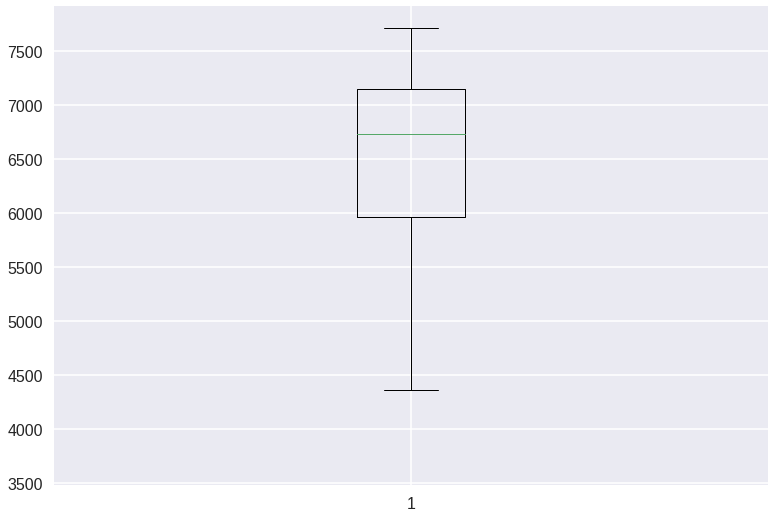

In [220]:
x = plt.boxplot([bcbp.T.iloc[0].T.values])

In [235]:
x["caps"][0].get_ydata(),x["caps"][1].get_ydata()

(array([ 4354.33333333,  4354.33333333]),
 array([ 7710.02298851,  7710.02298851]))

In [364]:
bcbp.T.iloc[0].T.values.mean(),bcbp.T.iloc[0].T.quantile(0.25),bcbp.T.iloc[0].T.quantile(0.75),bcbp.T.iloc[0].T.min(),bcbp.T.iloc[0].T.max()

(6517.0837638671946,
 5959.505747126437,
 7149.021551724138,
 3683.0,
 7710.022988505747)

In [244]:
bp2 = ax.axvline(0,4354.3,7710.02)
plt.show()

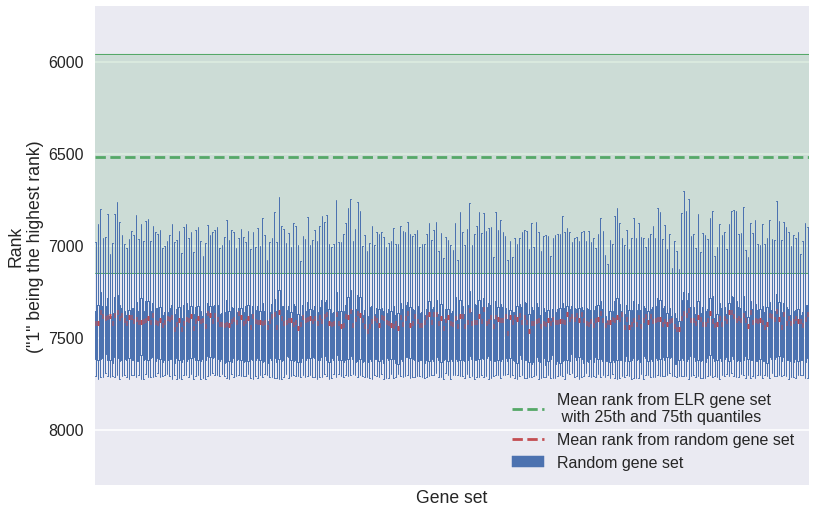

In [391]:
colors = sns.color_palette()
fig, ax = plt.subplots()
v=True
l = plt.axhline(5959,color=colors[1],linestyle="-",linewidth=1,visible=v)
u = plt.axhline(7149,color=colors[1],linestyle="-",linewidth=1,visible=v)
plt.axhline(6517.08,color=colors[1],linestyle="--")
to_plot = []
for i,p in rbp.T.iloc[:300].T.iteritems():
    to_plot.append(p[p.isnull()==False].values)
    
a = 1
bp1 = ax.boxplot(to_plot,
                whiskerprops={"alpha":a,"color":colors[0]},
                flierprops={"alpha":0.0,"color":colors[0]},
                boxprops={"alpha":a,"color":colors[0]},
                capprops={"alpha":a,"color":colors[0]},
                meanprops={"color":colors[2],"linewidth":5},
                medianprops={"alpha":0},
                meanline=True, 
                showmeans=True)

plt.ylabel("""Rank\n("1" being the highest rank)""")
plt.xlabel("Gene set")
plt.xticks([])
p1 = mpatches.Patch(color=colors[0],label="Random gene set")
l1 = plt.plot([],label="Mean rank from ELR gene set\n with 25th and 75th quantiles",color=colors[1],linestyle="--")
l2 = plt.plot([],label="Mean rank from random gene set",color=colors[2],linestyle="--")
p = mpatches.Rectangle(
    (0,5959), len(bp1["boxes"])+1,1190,
    fill=True, clip_on=True,transform=ax.transData,color=colors[1],alpha=0.2)
ax.add_patch(p)
plt.ylim(5700,8300)
plt.legend(handles=[l1[0],l2[0],p1],loc=4)
plt.gca().invert_yaxis()
plt.savefig("EMCON_bc_relevance.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [356]:
l.get_data()

([0, 1], [4354.3, 4354.3])

In [298]:
sns.color_palette()

[(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
 (0.33333333333333331, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.30588235294117649, 0.32156862745098042),
 (0.50588235294117645, 0.44705882352941179, 0.69803921568627447),
 (0.80000000000000004, 0.72549019607843135, 0.45490196078431372),
 (0.39215686274509803, 0.70980392156862748, 0.80392156862745101)]

/home/swatford/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in less_equal
  return umr_minimum(a, axis, None, out, keepdims)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

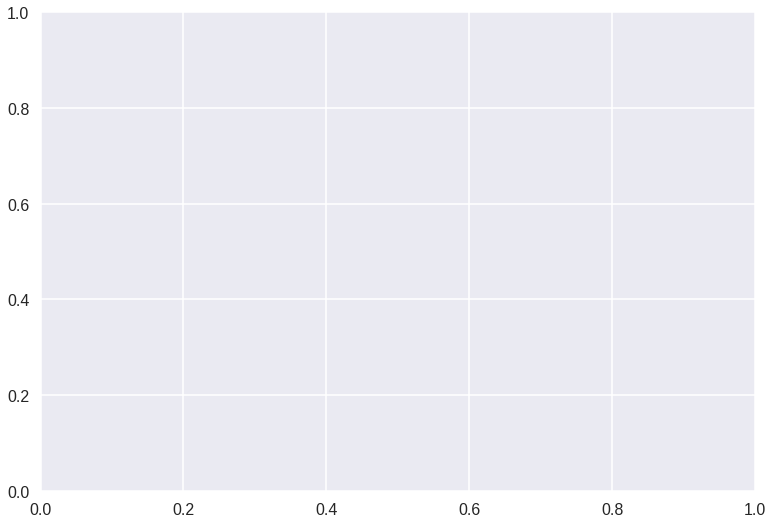

In [83]:
pd.Series(random_gene_npmi_ranks).hist(label="Randomly generated gene sets")
plt.xlabel("Rank")
plt.ylabel("Number of gene sets")

plt.axvline(x=bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].mean(),color="g",label="ELR gene set")
plt.legend()
plt.savefig("EMCON_bc_relevance.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [ ]:
for d in bc_results.columns.get_level_values("uid"):
    print(uid_name[d])

In [ ]:
set(bc_genes)-set(bc_results.index.values)

In [ ]:
pd.Series(random_gene_chi2_ranks).hist()
plt.title("chi2 distribution")
plt.axvline(x=bc_results.swaplevel(0,1,axis=1).chi2_rank.mean(axis=1)[bc_genes].mean(),color="r")
print(np.percentile(random_gene_chi2_ranks,5)-bc_results.swaplevel(0,1,axis=1).chi2_rank.mean(axis=1)[bc_genes].mean())

In [ ]:
pd.Series(random_gene_ll_ranks).hist()
plt.title("log-liklihood distribution")
plt.axvline(x=bc_results.swaplevel(0,1,axis=1).ll_rank.mean(axis=1)[bc_genes].mean(),color="r")
print(np.percentile(random_gene_ll_ranks,5)-bc_results.swaplevel(0,1,axis=1).ll_rank.mean(axis=1)[bc_genes].mean())

In [ ]:
print(bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].mean(),
      bc_results.swaplevel(0,1,axis=1).chi2_rank.mean(axis=1)[bc_genes].mean(),
      bc_results.swaplevel(0,1,axis=1).ll_rank.mean(axis=1)[bc_genes].mean()
     )

In [ ]:
uids = gene_uid[gene_uid.gd_freq>2].uid.unique()

In [ ]:
random_mesh_list = np.random.choice(uids,(3000,17))

In [ ]:
random_mesh_list_w_children = []
for i,rml in enumerate(random_mesh_list):
    rml_tns = uid_tn[uid_tn.uid.isin(rml)].tn.values
    random_mesh_list_w_children.append(list(rml)+
                                       list(db.medline.descs.distinct("uid",{"ancestors":{"$in":list(rml_tns)}})))

In [ ]:
searchable_gene_uid = gene_uid[(gene_uid.gd_freq>2) 
                               & (gene_uid.uid.isin(uids))].set_index("uid",drop=False)

In [ ]:
dfs = []
while len(dfs)<10000:
    rml = list(np.random.choice(uids,17))
    rml_tns = uid_tn[uid_tn.uid.isin(rml)].tn.values
    rml+= list(db.medline.descs.distinct("uid",{"ancestors":{"$in":list(rml_tns)}}))
    try:
        df = searchable_gene_uid.loc[rml].reset_index(drop=True).pivot(index="gene_id",
                                                                             columns="uid")
#         .npmi.fillna(0.0)
#         if len(set(df.index.values)&set(bc_genes))/len(bc_genes)>=0.8:
        dfs.append(df)
        print("dfs: ",len(dfs))
    except:
        pass

In [ ]:
bc_df = searchable_gene_uid.loc[bc_uids].reset_index(drop=True)
bc_df = bc_df[bc_df.gene_id.isnull()==False].drop_duplicates().pivot(
                                                                    index="gene_id",columns="uid",values="npmi")

In [ ]:
for c in bc_df:
    bc_df[c].update(pd.Series(index=bc_df[c][bc_df[c]<0.0].index,data=0.0))
bc_rank = bc_df.rank(ascending=False,
        na_option="bottom").loc[bc_genes].mean().mean()/len(bc_df.index.unique())

In [ ]:
random_mesh_ranks = []
for df in dfs:
#     for c in df:
#         df[c].update(pd.Series(index=df[c][df[c]<0.0].index,data=0.0))
    ranks = df.rank(na_option="bottom")
    random_mesh_ranks.append(((ranks.loc[bc_genes].mean().mean())/len(ranks.index.unique())))

In [ ]:
pd.Series(random_mesh_ranks).hist(label="Random MeSH Terms")
plt.axvline(bc_rank,c="r",label="BC MeSH Terms")
plt.legend(loc="upper right")
plt.xlim(0.4,0.6)
plt.title("Query Performance of Manually Selected MeSH Terms")
plt.xlabel("Average Rank (scaled to number of genes retrieved)")
plt.ylabel("Frequency")

In [ ]:
percentileofscore(random_mesh_ranks,bc_rank)

In [ ]:
bc_gwas_genes = pd.read_table("../data/SSI/BC_GWAS_genes.txt")

In [ ]:
bc_gwas_genes = bc_gwas_genes[bc_gwas_genes.Species=="Homo sapiens"].copy()

In [ ]:
bc_gwas_genes = bc_gwas_genes.To.unique()

In [ ]:
bc_df.rank(ascending=False,
        na_option="bottom").loc[bc_gwas_genes].mean().mean()/len(bc_df.index.unique())

In [ ]:
set(bc_gwas_genes) & set(bc_genes)

In [ ]:
len(bc_gwas_genes),len(bc_genes),len(set(bc_gwas_genes) | set(bc_genes))

In [ ]:
import pickle
with open("../data/SSI/bc_uids.p","wb") as f:
    pickle.dump(bc_uids,f)

In [ ]:
to_export = bc_results.swaplevel(0,1,axis=1).npmi_rank.copy()[["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]]

In [ ]:
to_export.columns = pd.MultiIndex.from_tuples([(uid_name[x],x) for x in to_export.columns],names=["name","uid"])

In [ ]:
to_export.index = pd.MultiIndex.from_tuples([(x,dict(db.genes.find_one({"gene_id":x}))["symbol"]) if x!=401388 else (7979,"SEM1") for x in to_export.index],names=["gene_id","symbol"])

In [ ]:
to_export.to_csv("bc_results.csv")

In [ ]:
set(bc_genes)|set(bc_results.index)

In [ ]:
bc_results_genes = set()
for col in bc_results.swaplevel(0,1,axis=1).npmi:
    for g in bc_results[col][bc_results[col].npmi>0.0].index:
        bc_results_genes.add(g)

In [ ]:
set(bc_genes) - bc_results_genes

In [ ]:
len(bc_genes)-5

In [ ]:
gene_uid[(gene_uid.gene_id==6531)&(gene_uid.gd_freq>2)&(gene_uid.npmi>0.0)]